# Research

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas_datareader.data as web
from datetime import datetime
import scipy.stats as scs
import statsmodels.api as sm
import scipy.optimize as sco
#import pandas_profiling
from functools import reduce

In [7]:
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))
import missingno as msno
p=print

# get index and fed data

f1 = 'USREC' # recession data from FRED

start = pd.to_datetime('1975-01-01')
end = pd.datetime.today()

mkt = '^GSPC'
MKT = (web.DataReader([mkt,'^VIX'], 'yahoo', start, end)['Adj Close']
      .resample('MS') # month start b/c FED data is month start
       .mean()
       .rename(columns={mkt:'SPX','^VIX':'VIX'})
       .assign(SPX_returns=lambda x: np.log(x['SPX']/x['SPX'].shift(1)))
       .assign(VIX_returns=lambda x: np.log(x['VIX']/x['VIX'].shift(1)))
       )

recData = (web.DataReader([f1], 'fred', start, end)
        .join(MKT, how='outer')
        .dropna())
# recessions are marked as 1 in the data
recs = recData.query('USREC==1')

# Select the three recessions over the time period
recs_pre = recs.loc['1990':'1991']
recs_2k = recs.loc['2001']
recs_2k8 = recs.loc['2008':]

# now we can grab the indices for the start
# and end of each recession
recspre_bgn = recs_pre.index[0]
recspre_end = recs_pre.index[-1]
recs2k_bgn = recs_2k.index[0]
recs2k_end = recs_2k.index[-1]
recs2k8_bgn = recs_2k8.index[0]
recs2k8_end = recs_2k8.index[-1]


ModuleNotFoundError: No module named 'missingno'

In [ ]:
test = web.get_data_yahoo('PFE',start=datetime(2005, 1, 1))

In [ ]:
HiLo = (test.groupby(pd.Grouper(freq="M")).max() + test.groupby(pd.Grouper(freq="M")).min())*.5
FiLa = (test.groupby(pd.Grouper(freq="M")).last() + test.groupby(pd.Grouper(freq="M")).first())*.5

In [ ]:
['PFE','XLU', 'XLY','XLF','XPH','SPY'] 

In [4]:
def spec_graph(sym, start=None, end=None):
    df_dict ={}
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    data = (data.groupby(pd.Grouper(freq="M")).last() + data.groupby(pd.Grouper(freq="M")).first())*.5
    data = np.log(data / data.shift(1))
    data = data[start:end]
    style=itertools.cycle(['--','-','-','-','-','-.'])
    width=itertools.cycle([9,5,5,5,5,9])
    msize=itertools.cycle([14,9,9,9,9,14])
    for x in sym:
        ax = data[x].plot(subplots=False, linestyle=next(style), marker='o', ms=next(msize), lw= next(width),figsize=(15,10))#, color= ["#34495e", "#2ecc71","#e74c3c", '#17becf'])
    ax.axvspan(recspre_bgn, recspre_end, color=sns.xkcd_rgb['grey'], alpha=0.5)
    ax.axvspan(recs2k_bgn, recs2k_end, color=sns.xkcd_rgb['grey'], alpha=0.5)
    ax.axvspan(recs2k8_bgn, recs2k8_end,  color=sns.xkcd_rgb['grey'], alpha=0.5)

    ax.axhline(0, color='k', linestyle='-', linewidth=1)

    ax.set_title("Monthly Returns", fontsize=28)

    ax.set_ylabel('Returns', fontsize = 28)
    ax.set_xlabel('')

    yticks = ax.get_yticks()
    ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in yticks]);

    dates_rng = pd.date_range(data.index[0], data.index[-1], freq='3m')
    plt.xticks(dates_rng, [dtz.strftime('%b-%y') for dtz in dates_rng], rotation=45, fontsize=28)

    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.legend(loc='upper left', fontsize=28, frameon=True).get_frame().set_edgecolor('blue')  


    

    # now to use tight layout
    plt.tight_layout()


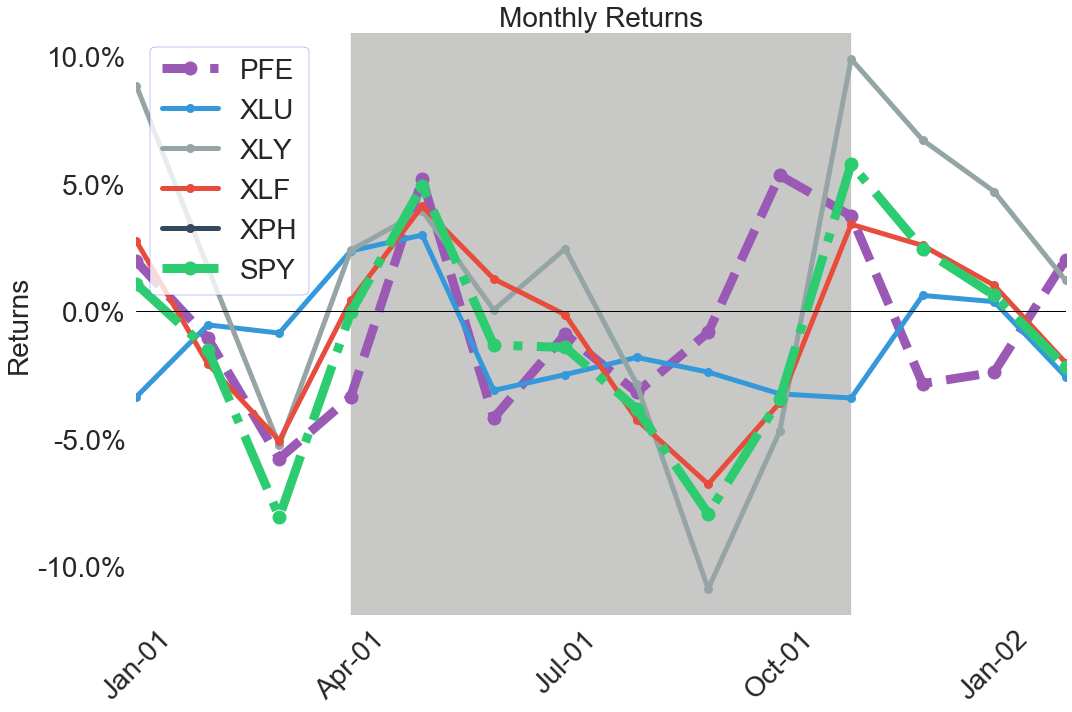

In [161]:
spec_graph(['PFE','XLU', 'XLY','XLF','XPH','SPY'],"01-2001", "02-2002")

In [5]:
spec_graph(['LOW','HD','SPY'],"10-2007", "08-2009")

NameError: name 'itertools' is not defined

In [ ]:
def pro_graph(sym, start=None, end=None):
    plot_labels = dict(zip(sym,[[x+'_min_',x+'_max_',x+'_min_idx_',x+'_max_idx_']for x in sym]))
    df_dict ={}
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    data = np.log(data / data.shift(1))
    data = data[start:end]
    
    for x in sym:
        plot_labels[x][0] = data[x].min()
        plot_labels[x][1] = data[x].max()
        plot_labels[x][2] = data[x].idxmin(axis=0, skipna=True)
        plot_labels[x][3] = data[x].idxmax(axis=0, skipna=True)
    
    fig, axes = plt.subplots(len(sym),1, figsize=(35,20), sharex=True)
    data[sym].plot(subplots=True, ax=axes, marker='o', ms=2, color= ["#34495e", "#2ecc71","#e74c3c", '#17becf'])

    for ax, col in zip(axes, sym):
        ax.axvspan(recspre_bgn, recspre_end, color=sns.xkcd_rgb['grey'], alpha=0.5)
        ax.axvspan(recs2k_bgn, recs2k_end, color=sns.xkcd_rgb['grey'], alpha=0.5)
        ax.axvspan(recs2k8_bgn, recs2k8_end,  color=sns.xkcd_rgb['grey'], alpha=0.5)
        
        ax.axhline(0, color='k', linestyle='-', linewidth=1)
        
        ax.set_title(col, fontsize=48)
        
        ax.set_ylabel('Returns', fontsize = 28)
        ax.set_xlabel('')
        
        yticks = ax.get_yticks()
        ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in yticks]);

        dates_rng = pd.date_range(data.index[0], data.index[-1], freq='1Y')
        plt.xticks(dates_rng, [dtz.strftime('%Y') for dtz in dates_rng], rotation=45, fontsize=28)
        
        ax.tick_params(axis='both', which='major', labelsize=28)
        ax.legend(loc='upper left', fontsize=28, frameon=True).get_frame().set_edgecolor('blue')  


    bbox_props = dict(boxstyle="round4, pad=0.6", fc='ivory', ec="black", lw=.5)
    
    for x in sym:
        axes[sym.index(x)].annotate('Global Max = {:.2%}\nDate = {}'
                         .format(plot_labels[x][1], plot_labels[x][3].strftime('%a, %Y-%m-%d')),
                    xy=(plot_labels[x][3], plot_labels[x][1]),  
                    xycoords='data',
                    xytext=(-150, -30),      
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",ec='black'),size=22, bbox=bbox_props)    

        axes[sym.index(x)].annotate('Global Min = {:.2%}\nDate = {}'
                         .format(plot_labels[x][0], plot_labels[x][2].strftime('%a, %Y-%m-%d')),
                    xy=(plot_labels[x][2], plot_labels[x][0]),  
                    xycoords='data',
                    xytext=(-150, 30),      
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",ec='black'),size=22, bbox=bbox_props) 
    # now to use tight layout
    plt.tight_layout()


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [179]:
#[data[x].first_valid_index() for x in sym]
#data.apply(lambda col: col.first_valid_index())

In [ ]:
sym = ['PFE','MRK','JNJ','NVS','GSK','SNY','RHHBY','ABBV']
df_dict ={}
for x in sym:
    df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
data = pd.DataFrame(df_dict)

In [ ]:
US = ['PFE','MRK','JNJ','ABBV']
EU = ['NVS','GSK','SNY','RHHBY']

In [ ]:
#general market
gm = ['SPY','FEZ','^VIX',]
#Defensive 
defense = ['XLV','XLU','XLP','WMT','GLD', 'SHY', 'LMT']
#Cyclicals
cycl =['^DJI','XPH','QQQ','AMZN','MSFT', 'XLY']

sym2 = gm + defense +cycl
df_dict2 ={}
for x in sym2:
    df_dict2[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
metrics = pd.DataFrame(df_dict2)

In [ ]:
pro_graph(US,'1999')

In [ ]:
#recession1 = datetime.datetime(1990,2,2)
#str(recession1 + datetime.timedelta(days=1))

In [ ]:
sym3 = ['SPY', '^VIX',"QQQ", "XLP", 'XLU']
#pro_graph(sym3,'1999')

In [ ]:
def etf_contstructor(sym, start=None, end=None):
    df_dict ={}
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    data= data.dropna()
    mc = pd.read_excel('marketcap.xlsx',index_col=0)
    mc = mc[sym]
    wghts = mc.div(mc.sum(axis=1), axis=0)
    start_date = wghts.index.min() - pd.DateOffset(day=1)
    end_date = wghts.index.max() + pd.DateOffset(day=31)
    dates = pd.date_range(start_date, end_date, freq='D')
    dates.name = 'date'
    data = data[start:end]
    wghts = wghts.reindex(dates, method='ffill')
    wghts = wghts[data.columns]
    wghts = wghts.loc[data.index]
    etf = pd.DataFrame(wghts.values*data.values, columns=wghts.columns, index=wghts.index).sum(axis=1)
    etf= pd.DataFrame(etf,columns=['etf'])
    return etf

In [ ]:
def etf_graph(etf_names, etfs_df, start=None, end=None):
    plot_labels = dict(zip(etf_names,[[x+'_min_',x+'_max_',x+'_min_idx_',x+'_max_idx_']for x in etf_names]))
    df_dict ={}
    data= etfs_df
    data = np.log(data / data.shift(1))
    data = data[start:end]
    for x in etf_names:
        plot_labels[x][0] = data[x].min()
        plot_labels[x][1] = data[x].max()
        plot_labels[x][2] = data[x].idxmin(axis=0, skipna=True)
        plot_labels[x][3] = data[x].idxmax(axis=0, skipna=True)
    
    fig, axes = plt.subplots(len(etf_names),1, figsize=(65,20), sharex=True)
    data[etf_names].plot(subplots=True, ax=axes, marker='o', ms=2)

    for ax, col in zip(axes, etf_names):
        ax.axvspan(recspre_bgn, recspre_end, color=sns.xkcd_rgb['grey'], alpha=0.5)
        ax.axvspan(recs2k_bgn, recs2k_end, color=sns.xkcd_rgb['grey'], alpha=0.5)
        ax.axvspan(recs2k8_bgn, recs2k8_end,  color=sns.xkcd_rgb['grey'], alpha=0.5)
    
        ax.axhline(0, color='k', linestyle='-', linewidth=1)
        
        ax.set_title(col, fontsize=48)
        
        ax.set_ylabel('Returns', fontsize =48)
        ax.set_xlabel('')
        
        yticks = ax.get_yticks()
        ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in yticks])

        dates_rng = pd.date_range(data.index[0], data.index[-1], freq='2Y')
        plt.xticks(dates_rng, [dtz.strftime('%Y') for dtz in dates_rng], rotation=45, fontsize=38)
        
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.legend(loc='upper left', fontsize=28, frameon=True).get_frame().set_edgecolor('blue')  


    bbox_props = dict(boxstyle="round4, pad=0.6", fc='ivory', ec="black", lw=.5)
    
    for x in etf_names:
        axes[etf_names.index(x)].annotate('Global Max = {:.2%}\nDate = {}'
                         .format(plot_labels[x][1], plot_labels[x][3].strftime('%a, %Y-%m-%d')),
                    xy=(plot_labels[x][3], plot_labels[x][1]),  
                    xycoords='data',
                    xytext=(-150, -30),      
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",ec='black'), size=32, bbox=bbox_props)    

        axes[etf_names.index(x)].annotate('Global Min = {:.2%}\nDate = {}'
                         .format(plot_labels[x][0], plot_labels[x][2].strftime('%a, %Y-%m-%d')),
                    xy=(plot_labels[x][2], plot_labels[x][0]),  
                    xycoords='data',
                    xytext=(-150, 30),      
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",ec='black'),size=32,bbox=bbox_props) 
    # now to use tight layout
    plt.tight_layout()


In [ ]:
US = ["PFE","MRK", "JNJ"]
EU = ["NVS", "GSK"]
US_pharma_new_sym = ["PFE","MRK","JNJ", "ABBV"]
EU_pharma_new_sym = ["NVS", "GSK", "RHHBY", "SNY"]

US = etf_contstructor(US,max([data[x].first_valid_index() for x in US]))
EU = etf_contstructor(EU,max([data[x].first_valid_index() for x in EU]))
US_pharma_new = etf_contstructor(US_pharma_new_sym,max([data[x].first_valid_index() for x in US_pharma_new_sym]))
EU_pharma_new = etf_contstructor(EU_pharma_new_sym,max([data[x].first_valid_index() for x in EU_pharma_new_sym]))

etfs = [EU, US]#, US_pharma_new, EU_pharma_new]
etf_names = ['EU','US']#, 'US_pharma_new', 'EU_pharma_new']
for i in range(len(etfs)):
    etfs[i].columns = [etf_names[i]]
etfs_df = reduce(lambda  left,right: pd.merge(left,right,how = 'outer',left_index=True, right_index=True), etfs)
etfs_df = etfs_df['1999':]

In [ ]:
etf_graph(etf_names, etfs_df[:-4])

In [ ]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

In [ ]:
#tmp = data.merge(ETF, how='outer', left_index=True, right_index=True)
#tmp.to_excel('tmp.xlsx')
#data.info()
#data.plot(figsize=(25, 10))

In [ ]:
def statsummary(sym, etf_ticks=sym,start=None, end = None):
    etf= etf_contstructor(etf_ticks,start)
    df_dict ={}
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    data = data.merge(etf, how='outer', left_index=True, right_index=True)
    data = data[start:end]
    data = np.log(data / data.shift(1))
    mean = data.mean()
    std =data.std()
    skew = data.skew()
    kurt = data.kurt()
    stats = pd.concat([mean, std, skew, kurt], axis=1)
    stats.columns = ['Mean',"Standard Deviation","Skew","Kurtosis"]
    stats.plot(kind='bar',figsize=(20,6),subplots=True)
    plt.show()
    display(stats)

In [ ]:
statsummary(sym2,sym,'2007','2009')

In [ ]:
statsummary(sym,sym,'2007','2009')

In [ ]:
rets = np.log(data / data.shift(1))
rets.cumsum().apply(np.exp).plot(figsize=(10, 6))
rets.cumsum().apply(np.exp). resample('1m', label='right').last().plot(figsize=(10, 6));

In [ ]:
#data2 = data.dropna()
#rollingstats = pd.DataFrame()
#window = 20
#for x in sym:
#    rollingstats[x+' '+'min'] = data2[x].rolling(window=window).min()
#    rollingstats[x+' '+'mean'] = data2[x].rolling(window=window).mean()
#    rollingstats[x+' '+'std'] = data2[x].rolling(window=window).std()
#    rollingstats[x+' '+'median'] = data2[x].rolling(window=window).median()
#    rollingstats[x+' '+'max'] = data2[x].rolling(window=window).max()
#    rollingstats[x+' '+'ewm'] = data2[x].ewm(halflife=0.5, min_periods=window).mean()


In [ ]:
#def roller(tick):
#    ax = rollingstats[[tick+' min', tick+' ewm', tick+' max']].iloc[-400:].plot(figsize=(10, 6), style=['g--', 'r--', 'g--'], lw=0.8)
#    data[tick].iloc[-400:].plot(ax=ax, lw=2.0);
#list(map(roller, sym))

In [ ]:
#rets = np.log(data / data.shift(1))
#rets.dropna(inplace=True)
#rets.plot(subplots=True, figsize=(10, 6));

In [ ]:
def corr(tick):
    tmp= ['spy']
    tmp.append(tick)
    df_dict ={}
    for x in tmp:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    rets = np.log(data / data.shift(1))
    rets.dropna(inplace=True)
    return rets

def corrg(tick):
    pd.plotting.scatter_matrix(corr(tick),alpha=0.2,diagonal='hist', figsize=(10, 6));

def corrgraph(tick):
    rets= corr(tick)
    ax = rets['spy'].rolling(window=252).corr(rets[tick]).plot(figsize=(10, 6))
    ax.axhline(rets.corr().iloc[0, 1], c='r')

corr_all = list(map(corr,sym))

In [ ]:
for i in range(len(sym)):
    corr_all[i].plot(subplots=True, figsize=(15, 6));

In [ ]:
#ols
#reg = np.polyfit(rets['spy'], rets['pfe'], deg=1)
#ax = rets.plot(kind='scatter', x='spy', y='pfe', figsize=(10, 6))
#ax.plot(rets['spy'], np.polyval(reg, rets['spy']), 'r', lw=2);
#time for statistics
#data = data.dropna()
#data.info()
#(data / data.iloc[0] * 100).plot(figsize=(10, 6))
#log_returns = np.log(data / data.shift(1))
#log_returns.head()
#log_returns.hist(bins=50, figsize=(10, 8));

In [ ]:
def print_statistics(array):
    sta = scs.describe(array)
    print('%14s %15s' % ('statistic', 'value'))
    print(30 * '-')
    print('%14s %15.5f' % ('size', sta[0]))
    print('%14s %15.5f' % ('min', sta[1][0]))
    print('%14s %15.5f' % ('max', sta[1][1]))
    print('%14s %15.5f' % ('mean', sta[2]))
    print('%14s %15.5f' % ('std', np.sqrt(sta[3])))
    print('%14s %15.5f' % ('skew', sta[4]))
    print('%14s %15.5f' % ('kurtosis', sta[5]))

    
def normality_tests(arr):
    print('Skew of data set  %14.3f' % scs.skew(arr))
    print('Skew test p-value %14.3f' % scs.skewtest(arr)[1])
    print('Kurt of data set  %14.3f' % scs.kurtosis(arr))
    print('Kurt test p-value %14.3f' % scs.kurtosistest(arr)[1])
    print('Norm test p-value %14.3f' % scs.normaltest(arr)[1])


In [ ]:
def aggregatestats(sym):
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
        data = pd.DataFrame(df_dict)
        data = np.log(data / data.shift(1))
        data = data.dropna()
        print('\nResults for symbol {}'.format(x))
        print(32 * '-')
        normality_tests(data[x])

In [ ]:
#aggregatestats(sym+sym2)

In [ ]:
def stats(sym,start=None,end=None):
    df_dict ={}
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    data = data[start:end]
    data = data.dropna(how ='all')
    rets = np.log(data / data.shift(1))
    corr = rets.corr()
    corr= corr
    return corr

In [ ]:
pd.set_option('display.max_columns', 999)
stats([x for x in sym if x!='ABBV']+sym2,"1-2007","12-2009")#,"06-2009")
#stats(sym+sym2,"12-1990").to_excel("recession.xlsx")

In [ ]:
def heatMap(sym,mirror,start=None,end=None):
    df_dict ={}
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    data = data[start:end]
    rets = np.log(data / data.shift(1))
    corr = rets.corr()
    fig, ax = plt.subplots(figsize=(12, 12))
    #plt.title("Heat Map|" + "  Start: {}  End: {}".format(start,end))
    if mirror == True:
        #Generate Heat Map, allow annotations and place floats in map
        sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
        #Apply xticks
        plt.xticks(range(len(corr.columns)), corr.columns);
        #Apply yticks
        plt.yticks(range(len(corr.columns)), corr.columns)
        #show plot
    else:
        # Drop self-correlations
        dropSelf = np.zeros_like(corr)
        dropSelf[np.triu_indices_from(dropSelf)] = True
        # Generate Color Map
        colormap = sns.diverging_palette(420, 10, as_cmap=True)
        # Generate Heat Map, allow annotations and place floats in map
        sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", mask=dropSelf)
        # Apply xticks
        plt.xticks(range(len(corr.columns)), corr.columns);
        # Apply yticks
        plt.yticks(range(len(corr.columns)), corr.columns)
        # show plot
    plt.show()    

heatMap([x for x in sym if x!='ABBV']+sym2,False,"1-1990")

In [ ]:
def etfheatMap(sym,mirror,start=None,end=None):
    df_dict ={}
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    data = data[start:end]
    US_pharma_sym = ["PFE","MRK", "JNJ"]
    EU_pharma_sym = ["RHHBY","NVS", "GSK"]
    US = etf_contstructor(US_pharma_sym,max([data[x].first_valid_index() for x in US_pharma_sym]))
    EU= etf_contstructor(EU_pharma_sym,max([data[x].first_valid_index() for x in EU_pharma_sym]))
    etfs = [US,EU]
    etf_names = ['US', 'EU']
    for i in range(len(etfs)):
        etfs[i].columns = [etf_names[i]]
    etfs_df = reduce(lambda  left,right: pd.merge(left,right,how = 'outer',left_index=True, right_index=True), etfs)
    etfs_df = etfs_df['1990':]
    data = data.join(etfs_df, how='outer')
    rets = np.log(data / data.shift(1))
    corr = rets.corr()
    fig, ax = plt.subplots(figsize=(12, 12))
    #plt.title("Heat Map|" + "  Start: {}  End: {}".format(start,end))
    if mirror == True:
        #Generate Heat Map, allow annotations and place floats in map
        sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
        #Apply xticks
        plt.xticks(range(len(corr.columns)), corr.columns);
        #Apply yticks
        plt.yticks(range(len(corr.columns)), corr.columns)
        #show plot
    else:
        # Drop self-correlations
        dropSelf = np.zeros_like(corr)
        dropSelf[np.triu_indices_from(dropSelf)] = True
        # Generate Color Map
        colormap = sns.diverging_palette(420, 10, as_cmap=True)
        # Generate Heat Map, allow annotations and place floats in map
        sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", mask=dropSelf, annot_kws={"size": 16})
        # Apply xticks
        plt.xticks(range(len(corr.columns)), corr.columns, fontsize=14);
        # Apply yticks
        plt.yticks(range(len(corr.columns)), corr.columns, fontsize=14)
        # show plot
    plt.show()    

etfheatMap(['PFE','MRK','JNJ',"RHHBY","NVS", "GSK"]+['SPY','^VIX','QQQ', 'XLP', 'XLU'],False,"12-2007", "6-2009")

In [ ]:
from math import sqrt
weights = np.random.random(noa)  
weights /= np.sum(weights)
weights = np.random.random(noa)  

#E[X]--np.sum(rets.mean() * weights) * 252
#var--np.dot(weights.T, np.dot(rets.cov() * 252, weights))
#vol--sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
def port_ret(weights):
             return np.sum(rets.mean() * weights) * 252
def port_vol(weights):
             return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

In [ ]:
prets = []
pvols = []
for p in range (5000):  
    weights = np.random.random(noa)  
    weights /= np.sum(weights)  
    prets.append(port_ret(weights))  
    pvols.append(port_vol(weights))  
prets = np.array(prets)
pvols = np.array(pvols)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

In [ ]:
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
eweights = np.array(noa * [1. / noa,])
min_func_sharpe(eweights)
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv = sco.minimize(port_vol, eweights,method='SLSQP', bounds=bnds,constraints=cons)

In [ ]:
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - tret}, {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)
trets = np.linspace(0.05, 0.2, 50)
tvols = []

for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')


In [ ]:
def bayes(tick):
    tmp= ['spy']
    tmp.append(tick)
    df_dict ={}
    for x in tmp:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    data=data.dropna()
    data = data / data.iloc[0] #normalize to 1
    return data
data = bayes('pfe')
data.iloc[-1] / data.iloc[0] - 1
data.corr()

In [ ]:
data.plot(figsize=(10,6))

In [ ]:
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())
plt.figure(figsize=(10, 6))
plt.scatter(data['spy'], data['pfe'], c=mpl_dates, marker='o', cmap='coolwarm')
plt.xlabel('spy')
plt.ylabel('pfe')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),format=mpl.dates.DateFormatter('%d %b %y'));

In [ ]:
import pymc3 as pm
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    y_est = alpha + beta * data['spy'].values
    likelihood = pm.Normal('pfe', mu=y_est, sd=sigma, observed=data['pfe'].values)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(500, tune=1000, start=start,progressbar=True)


In [ ]:
pm.summary(trace)

In [ ]:
fig = pm.traceplot(trace)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data['spy'], data['pfe'], c=mpl_dates,
         marker='o', cmap='coolwarm')
plt.xlabel('spy')
plt.ylabel('pfe')
for i in range(len(trace)):
    plt.plot(data['spy'],
          trace['alpha'][i] + trace['beta'][i] * data['spy'])

# Add Macroeconomic Information